In [2]:
import os
import sys

module_path = os.path.abspath(os.path.join('../..'))

if module_path not in sys.path:
    sys.path.append(module_path)


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import genpareto
from math import sqrt
from tensorflow import keras
import tensorflow as tf
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *

from helper import series_to_supervised
from model.cnn import cnn_4layer
from model.mlp import mlp_layer

2024-01-10 20:40:39.560148: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [4]:
# import random

# random.seed(10)
# print(random.random())

In [5]:
# https://keras.io/examples/timeseries/timeseries_weather_forecasting/#climate-data-timeseries
data = pd.read_csv("../../data/jena_climate_2009_2016_hourly.csv", index_col=0)
data.fillna(0, inplace=True)
data.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Date Time,,,,,,,,,,,,,,
2009-01-01 00:00:00,996.528000,-8.304000,265.118000,-9.120000,93.780000,3.260000,3.058000,0.202000,1.910000,3.068000,1309.196000,0.520000,1.002000,174.460000
2009-01-01 01:00:00,996.525000,-8.065000,265.361667,-8.861667,93.933333,3.323333,3.121667,0.201667,1.951667,3.133333,1307.981667,0.316667,0.711667,172.416667
2009-01-01 02:00:00,996.745000,-8.763333,264.645000,-9.610000,93.533333,3.145000,2.940000,0.201667,1.836667,2.950000,1311.816667,0.248333,0.606667,196.816667
2009-01-01 03:00:00,996.986667,-8.896667,264.491667,-9.786667,93.200000,3.111667,2.898333,0.210000,1.811667,2.906667,1312.813333,0.176667,0.606667,157.083333
2009-01-01 04:00:00,997.158333,-9.348333,264.026667,-10.345000,92.383333,3.001667,2.775000,0.231667,1.733333,2.780000,1315.355000,0.290000,0.670000,150.093333


### Preprocess

In [6]:
values = data.values

# specify the number of lag hours
n_hours = 24*3
n_features = data.shape[-1]
k = 12
split1 = 0.7
split2 = 0.85

# frame as supervised learning
reframed = series_to_supervised(values, n_hours, k)
print("reframed.shape:", reframed.shape)

reframed.shape: (70046, 1176)


In [7]:
# split into train and test sets
reframed_values = reframed.values
n_train_hours = int(len(reframed_values)*split1)
n_valid_hours = int(len(reframed_values)*split2)

train = reframed_values[:n_train_hours, :]
val = reframed_values[n_train_hours:n_valid_hours, :]
test = reframed_values[n_valid_hours:, :]


# split into input and outputs
n_obs = n_hours * n_features
feature_idx = 5
train_X, train_y = train[:, :n_obs], train[:, [n_obs + feature_idx + n_features * i for i in range(k)]]
val_X, val_y = val[:, :n_obs], val[:, [n_obs + feature_idx + n_features * i for i in range(k)]]
test_X, test_y = test[:, :n_obs], test[:, [n_obs + feature_idx + n_features * i for i in range(k)]]


print("train_X.shape, train_y.shape, val_X.shape, val_y.shape, test_X.shape, test_y.shape", 
      train_X.shape, train_y.shape, val_X.shape, val_y.shape, test_X.shape, test_y.shape
     )

train_X.shape, train_y.shape, val_X.shape, val_y.shape, test_X.shape, test_y.shape (49032, 1008) (49032, 12) (10507, 1008) (10507, 12) (10507, 1008) (10507, 12)


In [8]:
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))

train_X = scaler.fit_transform(train_X)
train_y = scaler.fit_transform(train_y)

val_X = scaler.fit_transform(val_X)
val_y = scaler.fit_transform(val_y)

test_X = scaler.fit_transform(test_X)
test_y = scaler.fit_transform(test_y)

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
val_X = val_X.reshape((val_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))

print("train_X.shape, train_y.shape, val_X.shape, val_y.shape, test_X.shape, test_y.shape", 
      train_X.shape, train_y.shape, val_X.shape, val_y.shape, test_X.shape, test_y.shape
     )

train_X.shape, train_y.shape, val_X.shape, val_y.shape, test_X.shape, test_y.shape (49032, 72, 14) (49032, 12) (10507, 72, 14) (10507, 12) (10507, 72, 14) (10507, 12)


### PM threshold

In [9]:
train_X_pm = train_X[:, 0, feature_idx]
print(train_X_pm.shape)

val_X_pm = val_X[:, 0, feature_idx]
print(val_X_pm.shape)

test_X_pm = test_X[:, 0, feature_idx]
print(test_X_pm.shape)

(49032,)
(10507,)
(10507,)


In [10]:
percentile = 95

merged_array = np.concatenate((train_X_pm, val_X_pm, test_X_pm))

percentile_pm = np.percentile(merged_array, percentile)

print("{}th Percentile of Daily Rain:".format(percentile), percentile_pm)

95th Percentile of Daily Rain: 0.48441203148316114


In [11]:
len(train_X_pm[train_X_pm > percentile_pm])

2206

In [12]:
# Extract excesses over the threshold from the heavy pm data only
excesses = np.abs(train_X_pm[train_X_pm > percentile_pm] - percentile_pm)
excesses.shape

(2206,)

In [13]:
# Fit Generalized Pareto Distribution (GPD) to excesses - returns shape (c), loc, scale for fitted distribution
c, loc, scale = genpareto.fit(excesses)


# Define a function to calculate weights based on the survival function of the GPD
def calculate_weights(pm, c, loc, scale, threshold):
    """
    survival function, also known as the complementary cumulative distribution function (CCDF), 
    is a function that gives the probability that a random variable X is greater than a certain value x
    """
    # Weights are the inverse of the survival function
    weights = np.where(pm > threshold, 
                       1 / (1 - genpareto.cdf(pm-threshold, c, loc=loc, scale=scale)),
#                        1 - genpareto.cdf(threshold - loc, c, loc=loc, scale=scale),
                       1.0
                      )  # Assign a default weight of 1 for non-extreme events

    # Normalize weights (optional, for stability in training)
    weights /= np.max(weights)
#     weights = (weights - np.min(weights)) / (np.max(weights) - np.min(weights)) + 0.1
#     weights = weights + 0.1
#     weights = np.exp(weights)
#     weights /= np.sum(weights)
    return weights

# Calculate weights for each sample in your dataset
weights = calculate_weights(train_X_pm, c, loc, scale, percentile_pm)
weights.shape

(49032,)

(array([4.8893e+04, 5.4000e+01, 3.3000e+01, 1.9000e+01, 5.0000e+00,
        1.0000e+00, 6.0000e+00, 4.0000e+00, 3.0000e+00, 2.0000e+00,
        2.0000e+00, 2.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 2.0000e+00]),
 array([0.00308015, 0.05292615, 0.10277214, 0.15261813, 0.20246412,
        0.25231012, 0.30215611, 0.3520021 , 0.40184809, 0.45169409,
        0.50154008, 0.55138607, 0.60123206, 0.65107805, 0.70092405,
        0.75077004, 0.80061603, 0.85046202, 0.90030802, 0.95015401,
        1.        ]),
 <BarContainer object of 20 artists>)

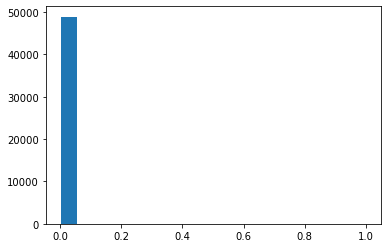

In [14]:
plt.hist(weights, bins=20)

In [15]:
np.save('sample_weights_pressure_EVT.npy', weights)

### Model

In [51]:
# ===== model parameters ======
mlp_unit1 = 128
mlp_unit2 = 128
mlp_unit3 = 64
mlp_unit4 = 64
mlp_unit5 = 32
mlp_unit6 = 32
mlp_unit7 = 16
mlp_unit8 = 16
dropout = 0.0
kernel_size = 2
pool_size = 2
learning_rate = 1e-4
decay_steps = 10000
decay_rate = 0.95
PATIENCE = 100
EPOCHS = 1000
BATCH = 512
opt_num = k
input_shape = train_X.shape[1:]

In [52]:
model = mlp_layer(input_shape=input_shape,
                   mlp_unit1=mlp_unit1,
                   mlp_unit2=mlp_unit2,
                   mlp_unit3=mlp_unit3,
                   mlp_unit4=mlp_unit4,
                   mlp_unit5=mlp_unit5,
                   mlp_unit6=mlp_unit6,
                   mlp_unit7=mlp_unit7,
                   mlp_unit8=mlp_unit8,
                   dropout=dropout,
                   masked_value=-1,
                   opt_num=opt_num
                  )
# model.summary()

In [53]:
model.compile(optimizer='adam',
              loss='mse',
              metrics=['mae']
             )


es = EarlyStopping(monitor='val_mae', mode='min', verbose=2, patience=PATIENCE)
mc = ModelCheckpoint('../../saved_models/pressure_all_weighted_EVT_95.h5', 
                     monitor='val_mae', 
                     mode='min', 
                     verbose=2, 
                     save_best_only=True
                    )


model.fit(train_X, train_y,
          validation_data=(val_X, val_y),
          epochs=EPOCHS,
          batch_size=BATCH,
          verbose=2,
          shuffle=True,
          callbacks=[es, mc],
          sample_weight=weights
         )

Epoch 1/1000
96/96 - 3s - loss: 5.7245e-05 - mae: 0.0839 - val_loss: 0.0176 - val_mae: 0.1177

Epoch 00001: val_mae improved from inf to 0.11772, saving model to ../../saved_models/pressure_all_weighted_EVT_95_cp.h5
Epoch 2/1000
96/96 - 1s - loss: 2.3102e-05 - mae: 0.0549 - val_loss: 0.0087 - val_mae: 0.0756

Epoch 00002: val_mae improved from 0.11772 to 0.07557, saving model to ../../saved_models/pressure_all_weighted_EVT_95_cp.h5
Epoch 3/1000
96/96 - 1s - loss: 1.7957e-05 - mae: 0.0485 - val_loss: 0.0081 - val_mae: 0.0719

Epoch 00003: val_mae improved from 0.07557 to 0.07187, saving model to ../../saved_models/pressure_all_weighted_EVT_95_cp.h5
Epoch 4/1000
96/96 - 1s - loss: 1.6167e-05 - mae: 0.0460 - val_loss: 0.0070 - val_mae: 0.0659

Epoch 00004: val_mae improved from 0.07187 to 0.06586, saving model to ../../saved_models/pressure_all_weighted_EVT_95_cp.h5
Epoch 5/1000
96/96 - 1s - loss: 1.4822e-05 - mae: 0.0438 - val_loss: 0.0086 - val_mae: 0.0768

Epoch 00005: val_mae did not 


Epoch 00053: val_mae did not improve from 0.04423
Epoch 54/1000
96/96 - 1s - loss: 1.0101e-05 - mae: 0.0374 - val_loss: 0.0050 - val_mae: 0.0489

Epoch 00054: val_mae did not improve from 0.04423
Epoch 55/1000
96/96 - 1s - loss: 9.0456e-06 - mae: 0.0349 - val_loss: 0.0050 - val_mae: 0.0478

Epoch 00055: val_mae did not improve from 0.04423
Epoch 56/1000
96/96 - 1s - loss: 8.6745e-06 - mae: 0.0342 - val_loss: 0.0049 - val_mae: 0.0467

Epoch 00056: val_mae did not improve from 0.04423
Epoch 57/1000
96/96 - 1s - loss: 8.9357e-06 - mae: 0.0348 - val_loss: 0.0050 - val_mae: 0.0468

Epoch 00057: val_mae did not improve from 0.04423
Epoch 58/1000
96/96 - 1s - loss: 8.7350e-06 - mae: 0.0343 - val_loss: 0.0053 - val_mae: 0.0480

Epoch 00058: val_mae did not improve from 0.04423
Epoch 59/1000
96/96 - 1s - loss: 8.6614e-06 - mae: 0.0342 - val_loss: 0.0050 - val_mae: 0.0471

Epoch 00059: val_mae did not improve from 0.04423
Epoch 60/1000
96/96 - 1s - loss: 1.0379e-05 - mae: 0.0373 - val_loss: 0.0

96/96 - 1s - loss: 7.5965e-06 - mae: 0.0327 - val_loss: 0.0064 - val_mae: 0.0550

Epoch 00110: val_mae did not improve from 0.04423
Epoch 111/1000
96/96 - 1s - loss: 7.5705e-06 - mae: 0.0324 - val_loss: 0.0067 - val_mae: 0.0582

Epoch 00111: val_mae did not improve from 0.04423
Epoch 112/1000
96/96 - 1s - loss: 8.4831e-06 - mae: 0.0345 - val_loss: 0.0066 - val_mae: 0.0564

Epoch 00112: val_mae did not improve from 0.04423
Epoch 113/1000
96/96 - 1s - loss: 7.5884e-06 - mae: 0.0326 - val_loss: 0.0071 - val_mae: 0.0581

Epoch 00113: val_mae did not improve from 0.04423
Epoch 114/1000
96/96 - 1s - loss: 7.1942e-06 - mae: 0.0319 - val_loss: 0.0071 - val_mae: 0.0577

Epoch 00114: val_mae did not improve from 0.04423
Epoch 115/1000
96/96 - 1s - loss: 7.1584e-06 - mae: 0.0318 - val_loss: 0.0074 - val_mae: 0.0605

Epoch 00115: val_mae did not improve from 0.04423
Epoch 116/1000
96/96 - 1s - loss: 7.6702e-06 - mae: 0.0329 - val_loss: 0.0071 - val_mae: 0.0574

Epoch 00116: val_mae did not improve

96/96 - 1s - loss: 6.6787e-06 - mae: 0.0310 - val_loss: 0.0089 - val_mae: 0.0673

Epoch 00166: val_mae did not improve from 0.04423
Epoch 167/1000
96/96 - 1s - loss: 6.0328e-06 - mae: 0.0298 - val_loss: 0.0095 - val_mae: 0.0697

Epoch 00167: val_mae did not improve from 0.04423
Epoch 168/1000
96/96 - 1s - loss: 5.9083e-06 - mae: 0.0296 - val_loss: 0.0098 - val_mae: 0.0711

Epoch 00168: val_mae did not improve from 0.04423
Epoch 169/1000
96/96 - 1s - loss: 6.1353e-06 - mae: 0.0300 - val_loss: 0.0111 - val_mae: 0.0771

Epoch 00169: val_mae did not improve from 0.04423
Epoch 170/1000
96/96 - 1s - loss: 8.6639e-06 - mae: 0.0346 - val_loss: 0.0095 - val_mae: 0.0735

Epoch 00170: val_mae did not improve from 0.04423
Epoch 171/1000
96/96 - 1s - loss: 9.8866e-06 - mae: 0.0368 - val_loss: 0.0082 - val_mae: 0.0645

Epoch 00171: val_mae did not improve from 0.04423
Epoch 172/1000
96/96 - 1s - loss: 6.6577e-06 - mae: 0.0308 - val_loss: 0.0093 - val_mae: 0.0687

Epoch 00172: val_mae did not improve